## edite,release _10 for training and release _11 for test
# same az 14 sep but edited release 10 and 11 

## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [14]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

# load and plot dataset from segments.ai

In [16]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset
from segments.utils import get_semantic_bitmap

# Initialize a SegmentsDataset from the release file
client = SegmentsClient('90318fc9b60907bf6cb076a9ca21a6b70ae935c5')
dataset_name_11 = 'idakh/line11_new'
dataset_name_8 = 'idakh/line_8'
dataset_name_10 = 'idakh/line10_new'
dataset_name_3 = 'idakh/line3'

# Get a list of image URLs

release_11= client.get_release(dataset_name_11, 'f0.11') # Alternatively: release = 'flowers-v1.0.json'
release_8 = client.get_release(dataset_name_8, 'f0.8') # Alternatively: release = 'flowers-v1.0.json'
release_10 = client.get_release(dataset_name_10, 'f0.10') # Alternatively: release = 'flowers-v1.0.json'
release_3 = client.get_release(dataset_name_3, 'f0.3') # Alternatively: release = 'flowers-v1.0.json'

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.66it/s]

Initialized dataset with 1 images.


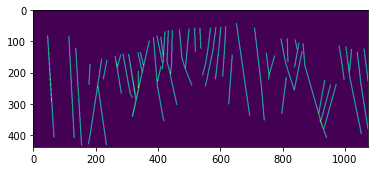

In [17]:
dataset = SegmentsDataset(release_11)
for sample in dataset:
    label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
    
plt.imshow(label)

In [4]:
np.unique(label)

array([0, 1])

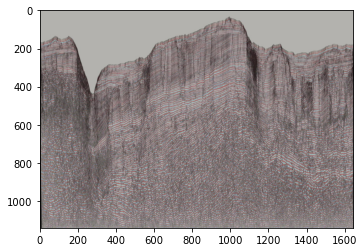

In [5]:
a = sample['image']
plt.imshow(np.array(a))

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1004.62it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.16it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.37it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.36it/s]

Initialized dataset with 1 images.


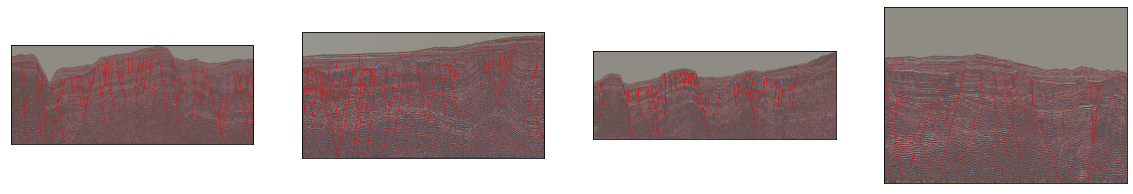

In [18]:
# from google.colab import widgets

def load_data_label(release):
    dataset = SegmentsDataset(release)
    for sample in dataset:
        label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
        data = np.asarray(sample['image']) / 255.
        #converting to grayscale
#         data = 0.2989*data[:,:,0] + 0.5870*data[:,:,1] + 0.1140*data[:,:,2]
#         data = Image.open(data_dir + sample['file_name'])
    label = np.asarray(label)
    return data, label


def plot_overlay(image, label, i):
    (tmax, xmax) = np.shape(label)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
#     img_gray = 0.2989*image[:,:,0] + 0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image_rgb = np.zeros((tmax,xmax,3), 'uint8')    
    image_rgb[:,:,0] = 255*image[:,:,0]
    image_rgb[:,:,1] = 255*image[:,:,1]
    image_rgb[:,:,2] = 255*image[:,:,2]
#     image_rgb[:,:,0:3] = 255. * image
#     image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGB') 
    background.paste(img, (0, 0), img)

#     background = Image.fromarray(image_rgb, mode='RGBA') 
#     print(image.shape)
#     print(label.shape)
#     background.paste(label, (0, 0), label)

    plt.subplot(1,4,i+1).imshow(background)
    plt.xticks([])
    plt.yticks([])



release = [release_11, release_8, release_10, release_3]
plt.figure(figsize=(20,20))
for i, rel in enumerate(release):
    
    data, label = load_data_label(rel)
    plot_overlay(data, label, i)
    plt.xticks([])
    plt.yticks([])

In [36]:
np.unique(label)

array([0, 2])

make training and validation dataset, (patchify, size of patch, ...),
# here I chenge window size from 64 to 128,
# I used release_10 for train   and  release_11 for validation
# I changed from gray scale to RGB
#  the patches  was changed from square shape to rectangular

In [19]:
def patchify(data, label, size_h, size_w, number, threshold):

    (t_max, x_max) = label.shape    
    X = np.zeros((number, size_h, size_w, 3))
    Y = np.zeros((number, size_h, size_w, 1))
        
    n = 0
    while n < number: 
        x = random.randint(size_w//2, x_max-size_w//2)
        t = random.randint(size_h//2, t_max-size_h//2)

        if np.count_nonzero(label[t-size_h//2:t+size_h//2, x-size_w//2:x+size_w//2]) > threshold:

            X[n,...]  = data[t-size_h//2:t+size_h//2, x-size_w//2:x+size_w//2]
            Y[n,:,:,0]  = label[t-size_h//2:t+size_h//2, x-size_w//2:x+size_w//2]
            n = n + 1
    return X, Y


# Parameters
size_h     = 256
size_w     = 16
threshold  = 100
num_train  = 10000
num_val    = 2000


# Validation data from inline 300
X_val = np.zeros((num_val,size_h,size_w,3))
Y_val = np.zeros((num_val,size_h,size_w,1))

seismic, label = load_data_label(release_11)

X_val, Y_val = patchify(seismic, label//2, size_h, size_w, num_val, threshold)


# Training data from inlines 100, 200, 400, 500
X_train = np.zeros((num_train,size_h,size_w,3))
Y_train = np.zeros((num_train,size_h,size_w,1))

release_list = [release_10]
n = 0
for release in release_list:
    seismic, label = load_data_label(release)
    
    X_train[n:n+num_train//1,...], Y_train[n:n+num_train//1,...] = patchify(seismic, label//2, size_h, size_w, num_train//1, threshold) 
    n += num_train//1

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Initialized dataset with 1 images.


KeyboardInterrupt: 

Before training, it's always a good idea to check the training data, so let's do that:

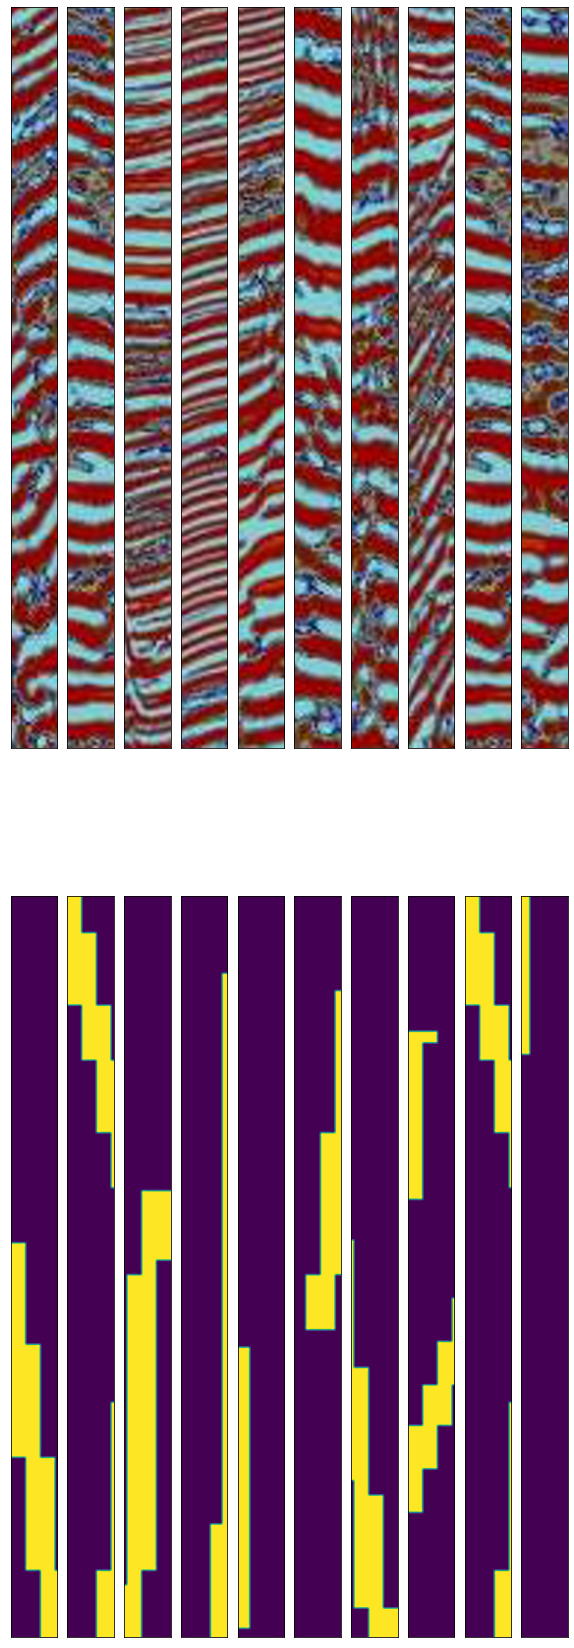

In [39]:
fig, axs = plt.subplots(2, 10, figsize=(10,30))

K = []
for m in range(10):
    k = random.randint(0,4000)
    K.append(k)
    axs[0,m].imshow(X_train[k,:,:,:], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[0,m].set_xticks([])
    axs[0,m].set_yticks([])

# K = np.stack(K)
for m in range(10):
    axs[1,m].imshow(Y_train[K[m],:,:,0], interpolation='spline16', aspect=1)
    axs[1,m].set_xticks([])
    axs[1,m].set_yticks([])
    k += 1


What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

## Training ##
To train our model, we need to define its architecture. 



In [20]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size_h, size_w, 3))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model



# size = 128
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 16, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 16, 16)  448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 16, 16)  2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 8, 16)   0           ['conv2d_1[0][0]']           

# Now you can train your convolutional neural net using the data generator:
##I increased epochs rank!(60 times my model was trained)

In [41]:
from keras.callbacks import CSVLogger
csvlogger = CSVLogger('history_20_sep_rec.csv', append=True)
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=30,
                    callbacks=[csvlogger])

model.save('checkpoint_tot3_20_rec_sep')

Epoch 1/30
313/313 [==============================] - 172s 540ms/step - loss: 0.4823 - acc: 0.8136 - val_loss: 0.2983 - val_acc: 0.9421
Epoch 2/30
313/313 [==============================] - 154s 493ms/step - loss: 0.4735 - acc: 0.8154 - val_loss: 0.2554 - val_acc: 0.9421
Epoch 3/30
313/313 [==============================] - 143s 457ms/step - loss: 0.4693 - acc: 0.8154 - val_loss: 0.2745 - val_acc: 0.9421
Epoch 4/30
313/313 [==============================] - 153s 487ms/step - loss: 0.4667 - acc: 0.8154 - val_loss: 0.2842 - val_acc: 0.9421
Epoch 5/30
313/313 [==============================] - 142s 454ms/step - loss: 0.4629 - acc: 0.8154 - val_loss: 0.2870 - val_acc: 0.9421
Epoch 6/30
313/313 [==============================] - 145s 462ms/step - loss: 0.4594 - acc: 0.8154 - val_loss: 0.3309 - val_acc: 0.9421
Epoch 7/30
313/313 [==============================] - 150s 480ms/step - loss: 0.4539 - acc: 0.8154 - val_loss: 0.3350 - val_acc: 0.9421
Epoch 8/30
313/313 [============================

INFO:tensorflow:Assets written to: checkpoint_tot3_20_rec_sep\assets


INFO:tensorflow:Assets written to: checkpoint_tot3_20_rec_sep\assets


To visualize our training, you can plot learning curves:

In [21]:
model.load_weights('checkpoint_tot3_20_rec_sep')

In [22]:
import pandas as pd
history = pd.read_csv('history_20_sep_rec.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'history_20_sep_rec.csv'

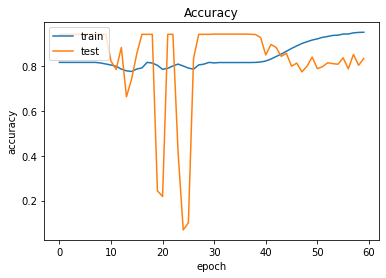

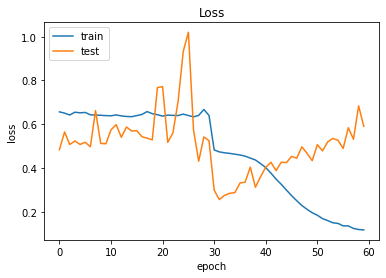

In [44]:
plt.plot(history.acc)
plt.plot(history.val_acc)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.loss)
plt.plot(history.val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

and a confusion matrix:

In [46]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_val)
Y_true = Y_val    

cm = np.zeros((2,2))

for n in range(Y_true.shape[0]):

  y_true = Y_true[n,:,:,0].round().flatten()
  y_pred = Y_pred[n,:,:,0].round().flatten()

  cm_batch = confusion_matrix(y_true, y_pred)
              

  cm = cm + cm_batch

63/63 [==============================] - 6s 87ms/step


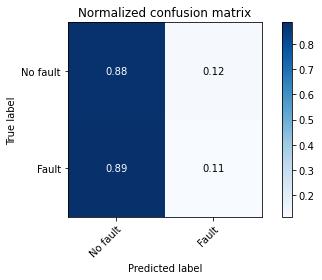

In [48]:
cmap=plt.cm.Blues
normalize = True

title = 'Normalized confusion matrix'


# Only use the labels that appear in the data
classes = ['No fault','Fault']

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
                ha="center", va='center',
                color="white" if cm_norm[i, j] > thresh else "black")
fig.tight_layout()

##Application##
Now we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image:

In [40]:
def tile(data, size_h, size_w, dt, dx):
    
    (t_max, x_max, _) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,size_h,size_w,3)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < size_h and x_max - x < size_w:
                data_patch[n,:,:,:] = data[t_max-size_h:t_max, x_max-size_w:x_max]
            elif x_max - x < size_w:
                data_patch[n,:,:,:] = data[t:t+size_h, x_max-size_w:x_max]
            elif t_max - t < size_h:
                data_patch[n,:,:,:] = data[t_max-size_h:t_max, x:x+size_w]
            else:
                data_patch[n,:,:,:] = data[t:t+size_h,x:x+size_w]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, size_h, size_w, dt, dx):

    data_new = np.zeros((t_max, x_max,3))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < size_h and x_max - x < size_w:
                data_new[t_max-size_h:t_max, x_max-size_w:x_max,:] += data_patch[n,:,:,:]
                count[t_max-size_h:t_max, x_max-size_w:x_max,0] += 1
            elif x_max - x < size_w:
                data_new[t:t+size_h, x_max-size_w:x_max,:] += data_patch[n,:,:,:]
                count[t:t+size_h, x_max-size_w:x_max,0] += 1 
            elif t_max - t < size_h:
                data_new[t_max-size_h:t_max, x:x+size_w,:] += data_patch[n,:,::]
                count[t_max-size_h:t_max, x:x+size_w,0] += 1
            else:
                data_new[t:t+size_h,x:x+size_w,:] += data_patch[n,:,:,:]
                count[t:t+size_h,x:x+size_w,:] += 1 
            n = n + 1

    return data_new/count

def plot_overlay(image, label, i):
    (tmax, xmax) = np.shape(label)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image[:,:,0]
    image_rgb[:,:,1] = 255*image[:,:,1]
    image_rgb[:,:,2] = 255*image[:,:,2]
#     image_rgb[:,:,0:3] = 255. * image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA') 
    background.paste(img, (0, 0), img)

#     background = Image.fromarray(image_rgb, mode='RGBA') 
#     print(image.shape)
#     print(label.shape)
#     background.paste(label, (0, 0), label)

    plt.subplot(1,5,i+1).imshow(background)
    plt.xticks([])
    plt.yticks([])



Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

Initialized dataset with 1 images.



C:\Users\ASUS\AppData\Local\Temp\ipykernel_14668\2495618882.py:48: RuntimeWarning: invalid value encountered in true_divide
  return data_new/count


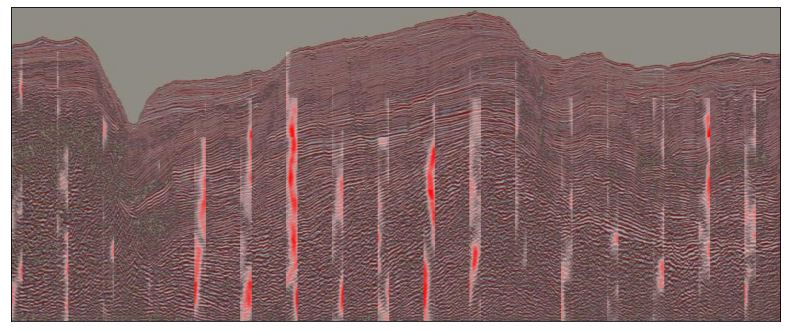

In [41]:
dt = 64
dx = 64

data, label = load_data_label(release_11)
# data = data[:700, :800]
# lable = label[:700, :800]
(t_max, x_max, _) = data.shape

plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size_h, size_w, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size_h, size_w, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Initialized dataset with 1 images.



C:\Users\ASUS\AppData\Local\Temp\ipykernel_14668\2495618882.py:48: RuntimeWarning: invalid value encountered in true_divide
  return data_new/count


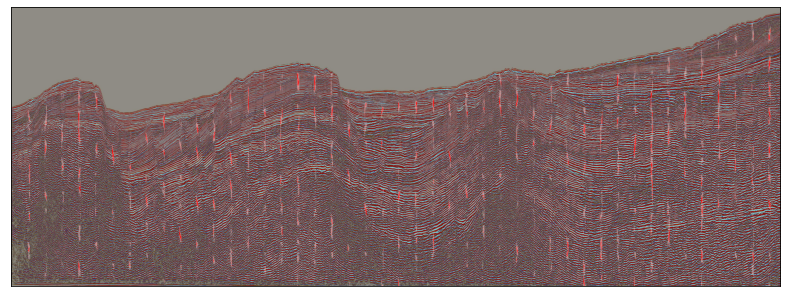

In [43]:
dt = 128
dx = 128
data, label = load_data_label(release_10)
(t_max, x_max, _) = data.shape

plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size_h, size_w, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size_h, size_w, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])

In [44]:

dt = 128
dx = 128
data, label = load_data_label(release_6)
(t_max, x_max, _) = data.shape


plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size_h, size_w, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size_h, size_w, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])

NameError: name 'release_6' is not defined

Not too bad for a first try! Check inline 300, which shows our predictions on a seismic line that it has not seen before. The model is able to find some of the clearer faults (bottom left) in the image. That's promising! Maybe we can even map these faults in a horizontal slice through the volume:

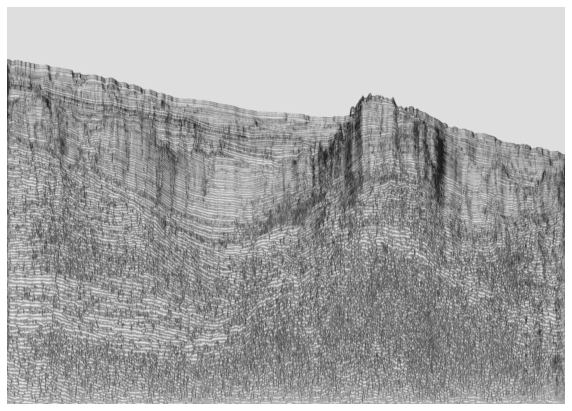

In [24]:
#depth = 420
#time_slice = data
plt.figure(figsize=(10,10))
plt.imshow(data, cmap= plt.cm.gray)
plt.axis('off')
plt.show()

Now let's predict! Again it will take a moment, since we have to process quite a bit of the volume

In [ ]:
# x is inline and y is depth
(xmax, ymax) = data.shape
nexp=(xmax-2*size)*(ymax-2*size)

batch_size = 1000

coord  = np.zeros((batch_size,2),int)
patch = np.zeros((batch_size,size,size,1))
prediction = np.zeros_like(data)



m=0
n_batch = 0
for x in range(size,xmax-size):
        for y in range(size,ymax-size):
            patch[m,:,:,0] = data[x-size//2:x+size//2, y-size//2:y+size//2]
            coord[m,:] = [x, y]                  
            m+=1        
            
            if m == batch_size:
                prediction[coord[:,0], coord[:,1]] = model.predict_on_batch(patch)[:,size//2,size//2,0]
                m=0
                
                print(str(n_batch+1) + ' of ' + str(round(nexp/batch_size)))
                n_batch += 1

1 of 1812
2 of 1812
3 of 1812
4 of 1812
5 of 1812
6 of 1812
7 of 1812
8 of 1812
9 of 1812
10 of 1812
11 of 1812
12 of 1812
13 of 1812
14 of 1812
15 of 1812
16 of 1812
17 of 1812
18 of 1812
19 of 1812
20 of 1812
21 of 1812
22 of 1812
23 of 1812
24 of 1812
25 of 1812
26 of 1812
27 of 1812
28 of 1812
29 of 1812
30 of 1812
31 of 1812
32 of 1812
33 of 1812
34 of 1812
35 of 1812
36 of 1812
37 of 1812
38 of 1812
39 of 1812
40 of 1812
41 of 1812
42 of 1812
43 of 1812
44 of 1812
45 of 1812
46 of 1812
47 of 1812
48 of 1812
49 of 1812
50 of 1812
51 of 1812
52 of 1812
53 of 1812
54 of 1812
55 of 1812
56 of 1812
57 of 1812
58 of 1812
59 of 1812
60 of 1812
61 of 1812
62 of 1812
63 of 1812
64 of 1812
65 of 1812
66 of 1812
67 of 1812
68 of 1812
69 of 1812
70 of 1812
71 of 1812
72 of 1812
73 of 1812
74 of 1812
75 of 1812
76 of 1812
77 of 1812
78 of 1812
79 of 1812
80 of 1812
81 of 1812
82 of 1812
83 of 1812
84 of 1812
85 of 1812
86 of 1812
87 of 1812
88 of 1812
89 of 1812
90 of 1812
91 of 1812
92 of 18

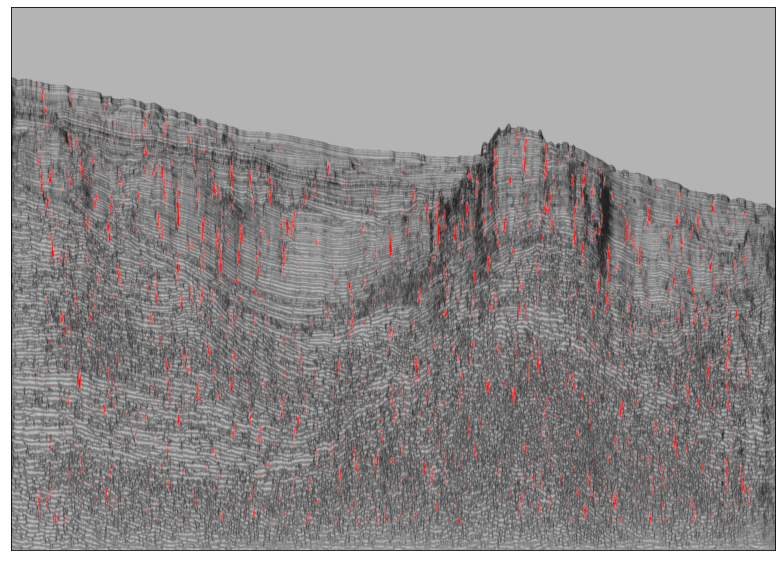

In [19]:
plt.figure(figsize=(80,10))
plot_overlay(data, prediction, 1)